Почитать CatBoost и возможно LigthBoost

# Градиентный бустинг

source:
- в общем виде с формулами https://habr.com/ru/company/ods/blog/327250/
- для чайников с конкретными реализациями алогоритма https://habr.com/ru/company/ods/blog/645887/

---

В чем суть: у нас есть какой-то базовый решающий алгоритм $h_t(\vec{x})$, на практике обычно это дерево малогой глубины (в общем случае может быть что угодно). Мы берем обчуаем этот баовый решающий алгоритм на наших данных, затем вычисляем ошибки (остатки) и итеративно учим алгоритм $t$ раз передавая ему в качестве аргумента остатки. В этом объясняется "Бустинг"

Слово "Градиентный" стоит тут потому, что в качстве остаков в общем случае используются функции потерь, которые могут принимать различные виды в роде $L=(y-\hat{y})^2$ или $L=\mid y-\hat{y} \mid$ и другие, более интересные, в роде логорифмических и экспоненциал. А на вход следующему решающему алгоритму $h_{t+1}(\vec{x})$ подается не результат самой функции потерь, а ее градиент с знаком минус (также  называемый псеводо остатком) $\vec{r}= - \nabla L(y, \hat{y})$. При этом $\vec{r_0} = L(y, \gamma)$, где $γ = const$, задаваемая пользователем. Иногда градиентный бустинг рассматривают как покоординатный градиентный спуск в пространстве функций.

Бывает полезно взвешивание классов, например, при imbalanced классах. Тогда $\vec{r} = - \vec{ω} \times \nabla L(y, \hat{y})$.

Важно чтобы базовый решающий алгоритм был weak learner'ом для того, чтобы модель не переобучалась на первой итерации, в следствии чего получальись около нулевые остатки, а функции потерь получались близкими к нулю, как и их градиенты.

Регуляризация градиентного бустинга. Для того, чтобы ослабить переобучение градиентного бустинга, применяются следующие техники:
- Subsampling. Мы обучаем каждый следующий weak learner не на всей обучающей выборке, а на случайной подвыборке. В этом случае градиентный бустинг называется стохастическим;
- Shrinkage. Мы умножаем результат полученный от каждой базовой функции на некоторое число меньше 1 (learning rate). Таким образом мы укорачиваем шаг в направлении градиента;
- Регуляризация самой базовой функции (как, например, уменьшение максимального кол-ва признаков max_features у дерева).

# XGBoost

## Параметры:

### Общие
- booster [default= gbtree ] Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions. dart add dropout techniques, что позволяет получить better results in some situations, [special dart params](https://xgboost.readthedocs.io/en/stable/parameter.html#additional-parameters-for-dart-booster-booster-dart)

- verbosity [default=1] Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug).

- seed [default=0] Random number seed

### Деревья
- eta [default=0.3, alias: learning_rate] Step size shrinkage
- max_depth [default=6]
- subsample [default=1] Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
  - sampling_method [default= uniform] The method to use to sample the training instances.
    - uniform: each training instance has an equal probability of being selected. Typically set subsample >= 0.5 for good results.
    - gradient_based: the selection probability for each training instance is proportional to the regularized absolute value of gradients (more specifically, ). subsample may be set to as low as 0.1 without loss of model accuracy. Note that this sampling method is only supported when tree_method is set to gpu_hist; other tree methods only support uniform sampling.
- lambda [default=1, alias: reg_lambda] L2 regularization term on weights.
- alpha [default=0, alias: reg_alpha] L1 regularization term on weights.
- tree_method [defoult='auto'] exact: Exact greedy algorithm. Enumerates all split candidates. approx: Approximate greedy algorithm using quantile sketch and gradient histogram. hist: Faster histogram optimized approximate greedy algorithm. gpu_hist: GPU implementation of hist algorithm.
- num_parallel_tree, [default=1] - Number of parallel trees constructed during each iteration. This option is used to support boosted random forest.

### Linear Booster
- lambda [default=0, alias: reg_lambda] L2 regularization term on weights.
- alpha [default=0, alias: reg_alpha] L1 regularization term on weights.
- feature_selector [default= cyclic] Feature selection and ordering method
  - cyclic: Deterministic selection by cycling through features one at a time.
  - shuffle: Similar to cyclic but with random feature shuffling prior to each update.
  - random: A random (with replacement) coordinate selector.
  - greedy: Select coordinate with the greatest gradient magnitude. It has O(num_feature^2) complexity. It is fully deterministic. It allows restricting the selection to top_k features per group with the largest magnitude of univariate weight change, by setting the top_k parameter. Doing so would reduce the complexity to O(num_feature*top_k).
  - thrifty: оптимизированный жадный

### Learning tasks

objective [default=reg:squarederror]

- reg:squarederror: regression with squared loss.

- reg:squaredlogerror: regression with squared log loss. All input labels are required to be greater than -1. Also, see metric rmsle for possible issue with this objective.

- reg:logistic: logistic regression

- reg:pseudohubererror: regression with Pseudo Huber loss, a twice differentiable alternative to absolute loss.

- reg:gamma: gamma regression with log-link. Output is a mean of gamma distribution. It might be useful, e.g., for modeling insurance claims severity, or for any outcome that might be gamma-distributed.

- reg:tweedie: Tweedie regression with log-link. It might be useful, e.g., for modeling total loss in insurance, or for any outcome that might be Tweedie-distributed.

- binary:logistic: logistic regression for binary classification, output probability

- binary:logitraw: logistic regression for binary classification, output score before logistic transformation

- binary:hinge: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.

- count:poisson –poisson regression for count data, output mean of Poisson distribution

  - max_delta_step is set to 0.7 by default in Poisson regression (used to safeguard optimization)

- survival:cox: Cox regression for right censored survival time data (negative values are considered right censored). Note that predictions are returned on the hazard ratio scale (i.e., as HR = exp(marginal_prediction) in the proportional hazard function h(t) = h0(t) * HR).

- survival:aft: Accelerated failure time model for censored survival time data. See Survival Analysis with Accelerated Failure Time for details.

  - aft_loss_distribution: Probability Density Function used by survival:aft objective and aft-nloglik metric.

- multi:softmax: set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)

- multi:softprob: same as softmax, but output a vector of ndata * nclass, which can be further reshaped to ndata * nclass matrix. The result contains predicted probability of each data point belonging to each class.

- rank:pairwise: Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized

- rank:ndcg: Use LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized

- rank:map: Use LambdaMART to perform list-wise ranking where Mean Average Precision (MAP) is maximized

Для сохраниея модели можно воспользоваться их методом. Иногда лучше все же pickle, посткольку XGBoost сохраняют не все, например, кастомную ф-цию потерь.

In [ ]:
bst.save_model('model_file_name.json')

bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('model.bin')  # load data

# dump model with feature map
bst.dump_model('dump.raw.txt', 'featmap.txt')

# Пример использования классификатора определенного в стиле sklearn

[0]	validation_0-error:0.035211	validation_0-logloss:0.611242	validation_1-error:0.013986	validation_1-logloss:0.60796
[1]	validation_0-error:0.028169	validation_0-logloss:0.544344	validation_1-error:0.027972	validation_1-logloss:0.539888
[2]	validation_0-error:0.028169	validation_0-logloss:0.488861	validation_1-error:0.027972	validation_1-logloss:0.483808
[3]	validation_0-error:0.030516	validation_0-logloss:0.440187	validation_1-error:0.027972	validation_1-logloss:0.433797
[4]	validation_0-error:0.028169	validation_0-logloss:0.400012	validation_1-error:0.027972	validation_1-logloss:0.393697
[5]	validation_0-error:0.030516	validation_0-logloss:0.364566	validation_1-error:0.027972	validation_1-logloss:0.357868
[6]	validation_0-error:0.025822	validation_0-logloss:0.331164	validation_1-error:0.027972	validation_1-logloss:0.324744
[7]	validation_0-error:0.021127	validation_0-logloss:0.302654	validation_1-error:0.027972	validation_1-logloss:0.297326
[8]	validation_0-error:0.025822	validatio

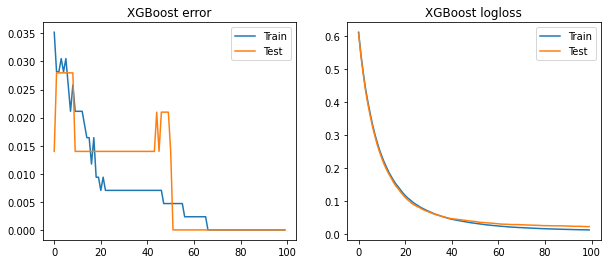

In [11]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# load data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# fit model in sklearn style
model = xgb.XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(epochs)

# plot error
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(x_axis, results['validation_0']['error'], label='Train')
ax1.plot(x_axis, results['validation_1']['error'], label='Test')
ax1.legend()
ax1.set_title('XGBoost error')

# plot logloss
ax2.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax2.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax2.legend()
ax2.set_title('XGBoost logloss')
plt.show()

# Пример использованияв классическом стиле с early_stopping_rounds

early_stopping_rounds = n совместно с заданым evals позволяет не обучать модель на всех 100 раундах, а остановить ее вычисление при условии, что за последние n раундов не было улучшенией в показателях метрики на проверочной выборке (если она задана)

In [23]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# load data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# fit model in sklearn style
param = {}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
# early_stopping_rounds=5 - только в качестве примера, лучше ставить больше
bst = xgb.train(param, dtrain, early_stopping_rounds=5, evals=[(dtrain, 'train'), (dtest, 'valid')])

# ypred = bst.predict(dtest, iteration_range=(0, bst.best_iteration)) новый варант записи, collab библиотеку еще не обновил
# делаем предсказания с лучшей моделью
ypred = bst.predict(dtest, ntree_limit=bst.best_iteration)

[0]	train-rmse:0.355572	valid-rmse:0.374069
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:0.252427	valid-rmse:0.297782
[2]	train-rmse:0.179781	valid-rmse:0.25643
[3]	train-rmse:0.1286	valid-rmse:0.22045
[4]	train-rmse:0.092658	valid-rmse:0.201093
[5]	train-rmse:0.067341	valid-rmse:0.191152
[6]	train-rmse:0.050496	valid-rmse:0.186409
[7]	train-rmse:0.038848	valid-rmse:0.182841
[8]	train-rmse:0.030839	valid-rmse:0.181457
[9]	train-rmse:0.024669	valid-rmse:0.180786
